

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [2]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

## Load the data

In [3]:
import os

# data_path = "/kaggle/input/tiny-genimage-radiomic-features"
# biggan_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_biggan/train/features_RGB.csv"), index_col=0)
# vqdm_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_vqdm/train/features_RGB.csv"), index_col=0)
# sdv5_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_sdv5/train/features_RGB.csv"), index_col=0)
# wukong_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_wukong/train/features_RGB.csv"), index_col=0)
# adm_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0508_adm/train/features_RGB.csv"), index_col=0)
# glide_train = pd.read_csv(os.path.join(data_path, "imagenet_glide/train/features_RGB.csv"), index_col=0)
# midjourney_train = pd.read_csv(os.path.join(data_path, "imagenet_midjourney/train/features_RGB.csv"), index_col=0)
# mid_sd = pd.concat([sdv5_train, midjourney_train])
# combined_train = pd.concat([biggan_train, vqdm_train, sdv5_train, wukong_train, adm_train, glide_train, midjourney_train])

# datasets_train = {
#     "biggan": biggan_train,
#     "vqdm": vqdm_train,
#     "sdv5": sdv5_train,
#     "wukong": wukong_train,
#     "adm": adm_train,
#     "glide": glide_train,
#     "midjourney": midjourney_train,
#     "mid_sd": mid_sd,
#     "combined": combined_train,
# }

data_path = "/kaggle/input/synthbuster-features"
suffix = "train/seed_44.csv"
dalle2 = pd.read_csv(os.path.join(data_path, "dalle2", suffix), index_col=0)
dalle3 = pd.read_csv(os.path.join(data_path, "dalle3", suffix), index_col=0)
firefly = pd.read_csv(os.path.join(data_path, "firefly", suffix), index_col=0)
glide = pd.read_csv(os.path.join(data_path, "glide", suffix), index_col=0)
midjourney = pd.read_csv(os.path.join(data_path, "midjourney", suffix), index_col=0)
sd_1_3 = pd.read_csv(os.path.join(data_path, "sd_1_3", suffix), index_col=0)
sd_1_4 = pd.read_csv(os.path.join(data_path, "sd_1_4", suffix), index_col=0)
sd_2 = pd.read_csv(os.path.join(data_path, "sd_2", suffix), index_col=0)
sd_xl = pd.read_csv(os.path.join(data_path, "sd_xl", suffix), index_col=0)

datasets_train = {
    "dalle2": dalle2,
    "dalle3": dalle3,
    "firefly": firefly,
    "glide": glide,
    "midjourney": midjourney,
    "sd_1_3": sd_1_3,
    "sd_1_4": sd_1_4,
    "sd_2": sd_2,
    "sd_xl": sd_xl,
}

In [4]:
# biggan_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_biggan/val/features_RGB.csv"), index_col=0)
# vqdm_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_vqdm/val/features_RGB.csv"), index_col=0)
# sdv5_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_sdv5/val/features_RGB.csv"), index_col=0)
# wukong_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_wukong/val/features_RGB.csv"), index_col=0)
# adm_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0508_adm/val/features_RGB.csv"), index_col=0)
# glide_test = pd.read_csv(os.path.join(data_path, "imagenet_glide/val/features_RGB.csv"), index_col=0)
# midjourney_test = pd.read_csv(os.path.join(data_path, "imagenet_midjourney/val/features_RGB.csv"), index_col=0)

# datasets_test = {
#     "biggan": biggan_test,
#     "vqdm": vqdm_test,
#     "sdv5": sdv5_test,
#     "wukong": wukong_test,
#     "adm": adm_test,
#     "glide": glide_test,
#     "midjourney": midjourney_test
# }

## Data preparation

In [5]:
def drop_columns(df, drop_only_diagnostic=False):
    to_drop = list()
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            to_drop.append(column)
        elif 'diagnostics' in column:
            to_drop.append(column)
        elif 'Mask' in column:
            to_drop.append(column)        
    df.drop(to_drop, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    for column in df.columns:
        if column not in base_columns:
            df.drop(column, axis=1, inplace=True)

### Drop unimportant columns

In [6]:
# We drop only columns from train set
for key, df in datasets_train.items():
    preprocess_dataset(df, drop_only_diagnostic=True)

### Split into train and test set

In [7]:
from sklearn.model_selection import train_test_split

X_train = {}
X_val = {}

y_train = {}
y_val = {}

Image_train = {}
Image_val = {}

for key, df in datasets_train.items():
    X = df.drop('Category', axis=1)
    y = df['Category']
    
    # get train, val and test sets
    X_train[key], X_val[key], y_train[key], y_val[key] = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
    Image_train[key] = X_train[key]['Image']
    Image_val[key] = X_val[key]['Image']
    
    X_train[key] = X_train[key].drop('Image', axis=1)
    X_val[key] = X_val[key].drop('Image', axis=1)

### Scale the data

In [8]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}
X_train_scaled = {}
for key in datasets_train.keys():
    scalers[key] = MinMaxScaler()
    X_train_scaled[key] = scalers[key].fit_transform(X_train[key])
    X_train_scaled[key] = pd.DataFrame(X_train_scaled[key], columns=X_train[key].columns)

## Model training

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

models = {}
for dataset_name in datasets_train.keys():
    print(f"\n\nTraining set: {dataset_name}\n")

    models_temp = [
#         HistGradientBoostingClassifier(random_state=SEED),
#         LinearDiscriminantAnalysis(),
#         RandomForestClassifier(random_state=SEED),
        LinearSVC(random_state=SEED),
    ]

    model_temp_dict = { model.__class__.__name__: model for model in models_temp }

    for name, model in model_temp_dict.items():
        model = model.fit(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())
        print(f"Finished training {name}.")
        print(f"Training accuracy: {model.score(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())}")
        
    models[dataset_name] = model_temp_dict



Training set: dalle2



/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: dalle3



/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: firefly



/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: glide

Finished training LinearSVC.
Training accuracy: 1.0


Training set: midjourney



/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: sd_1_3



/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: sd_1_4



/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: sd_2



/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: sd_xl

Finished training LinearSVC.
Training accuracy: 1.0


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Evaluation

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X_test, y_test, print_results=True, name=None):
    if name is not None:
        name = model.__class__.__name__
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    if print_results:
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
    
    return accuracy, f1, precision, recall

def plot_confusion_matrix(model, X_test, y_test, name=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(name)
    plt.show()

In [11]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for val_dataset_name in X_val.keys():
        print(f"\n\nValidation set: {val_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print()  
            X_val_scaled = scalers[dataset_name].transform(X_val[val_dataset_name])
            X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val[val_dataset_name].columns)
            accuracy, f1, precision, recall = evaluate_model(model, X_val_scaled, y_val[val_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall
            }
            results[(dataset_name, val_dataset_name, model_name)] = model_results
            





 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000


Validation set: dalle3

Model: LinearSVC
Accuracy: 0.8219
F1: 0.8167
Precision: 0.8693
Recall: 0.8219


Validation set: firefly

Model: LinearSVC
Accuracy: 0.5406
F1: 0.4252
Precision: 0.7628
Recall: 0.5406


Validation set: glide

Model: LinearSVC
Accuracy: 0.8594
F1: 0.8569
Precision: 0.8907
Recall: 0.8594


Validation set: midjourney

Model: LinearSVC
Accuracy: 0.7438
F1: 0.7272
Precision: 0.8317
Recall: 0.7438


Validation set: sd_1_3

Model: LinearSVC
Accuracy: 0.7469
F1: 0.7310
Precision: 0.8330
Recall: 0.7469


Validation set: sd_1_4

Model: LinearSVC
Accuracy: 0.7156
F1: 0.6925
Precision: 0.8200
Recall: 0.7156


Validation set: sd_2

Model: LinearSVC
Accuracy: 0.8094
F1: 0.8029
Precision: 0.8627
Recall: 0.8094


Validation set: sd_xl

Model: LinearSVC
Accuracy: 0.9281
F1: 0.9278
Precision: 0.9373
Recall: 0.9281




 *** Eval

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906


Validation set: firefly

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906


Validation set: glide



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000


Validation set: midjourney

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906


Validation set: sd_1_3



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906


Validation set: sd_1_4

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906


Validation set: sd_2



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906


Validation set: sd_xl

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.9313
F1: 0.9311
Precision: 0.9382
Recall: 0.9313


Validation set: dalle3

Model: LinearSVC
Accuracy: 0.9812
F1: 0.9813
Precision: 0.9816
Recall: 0.9812


Validation set: firefly

Model: LinearSVC
Accuracy: 0.9125
F1: 0.9121
Precision: 0.9239
Recall: 0.9125


Validation set: glide

Model: LinearSVC
Accuracy: 0.8469
F1: 0.8439
Precision: 0.8802
Recall: 0.8469


Validation set: midjourney

Model: LinearSVC
Accuracy: 0.9844
F1: 0.9844
Precision: 0.9846
Recall: 0.9844


Validation set: sd_1_3

Model: LinearSVC
Accuracy: 0.9000
F1: 0.8993
Precision: 0.9148
Recall: 0.9000


Validation set: sd_1_4

Model: LinearSVC
Accuracy: 0.8812
F1: 0.8800
Precision: 0.9019
Recall: 0.8812


Validation set: sd_2

Model: LinearSVC
Accuracy: 0.8219
F1: 0.8171
Precision: 0.8657
Recall: 0.8219


Validation set: sd_xl

Model: LinearSVC
Accuracy: 0.9969
F1: 0.9969
Precision: 0.9969
Recall: 0.9969




 *** Evaluating models trained on sd_1_3. ***


Validation set: dalle2

Model: Linear

In [12]:
# Create a heatmap of results
df_results = pd.DataFrame(results).T
df_results.reset_index(inplace=True)
df_results.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall"]

In [13]:
# # Get only for the LDA model
# LDA = df_results[df_results["model"] == "LinearDiscriminantAnalysis"]
# # Leave only the accuracy, train_dataset, and val_dataset columns
# LDA = LDA[["train_dataset", "val_dataset", "accuracy"]]
# # Pivot the table
# df_pivot = LDA.pivot(index="train_dataset", columns="val_dataset", values="accuracy")
# # reorganize columns and indexes in order Midjourney, SDv5, ADM, GLIDE, WukoNG, VQDM, BigGAN, Combined
# df_pivot = df_pivot.reindex(index=["midjourney", "sdv5", "adm", "glide", "wukong", "vqdm", "biggan", "mid_sd", "combined"])
# df_pivot = df_pivot.reindex(columns=["midjourney", "sdv5", "adm", "glide", "wukong", "vqdm", "biggan", "mid_sd", "combined"])

# plt.figure(figsize=(10, 7))
# plt.imshow(df_pivot, cmap='Reds', interpolation='nearest')
# plt.colorbar()
# plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
# plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
# plt.xlabel("Validation dataset")
# plt.ylabel("Train dataset")
# plt.title("Accuracy - LDA")
# plt.show()

# df_pivot


In [14]:
# # add average accuracy for each train dataset (don't include combined)
# df_pivot["average"] = df_pivot.mean(axis=1)
# df_pivot

In [15]:
# # Get only for the HistBoost model
# HistBoost = df_results[df_results["model"] == "HistGradientBoostingClassifier"]
# # Leave only the accuracy, train_dataset, and val_dataset columns
# HistBoost = HistBoost[["train_dataset", "val_dataset", "accuracy"]]
# # Pivot the table
# df_pivot = HistBoost.pivot(index="train_dataset", columns="val_dataset", values="accuracy")
# df_pivot = df_pivot.reindex(index=["biggan", "vqdm", "sdv5", "wukong", "adm", "glide", "midjourney", "combined"])
# df_pivot = df_pivot.reindex(columns=["biggan", "vqdm", "sdv5", "wukong", "adm", "glide", "midjourney", "combined"])

# # reorganize columns and indexes in order Midjourney, SDv5, ADM, GLIDE, WukoNG, VQDM, BigGAN, Combined
# df_pivot = df_pivot.reindex(index=["midjourney", "sdv5", "adm", "glide", "wukong", "vqdm", "biggan", "combined"])
# df_pivot = df_pivot.reindex(columns=["midjourney", "sdv5", "adm", "glide", "wukong", "vqdm", "biggan", "combined"])

# plt.figure(figsize=(10, 7))
# plt.imshow(df_pivot, cmap='Blues', interpolation='nearest')
# plt.colorbar()
# plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
# plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
# plt.xlabel("Validation dataset")
# plt.ylabel("Train dataset")
# plt.title("Accuracy - HistGradientBoosting")
# plt.show()

# df_pivot

In [16]:
# # add average accuracy for each train dataset (don't include combined)
# df_pivot["average"] = df_pivot.mean(axis=1)
# df_pivot

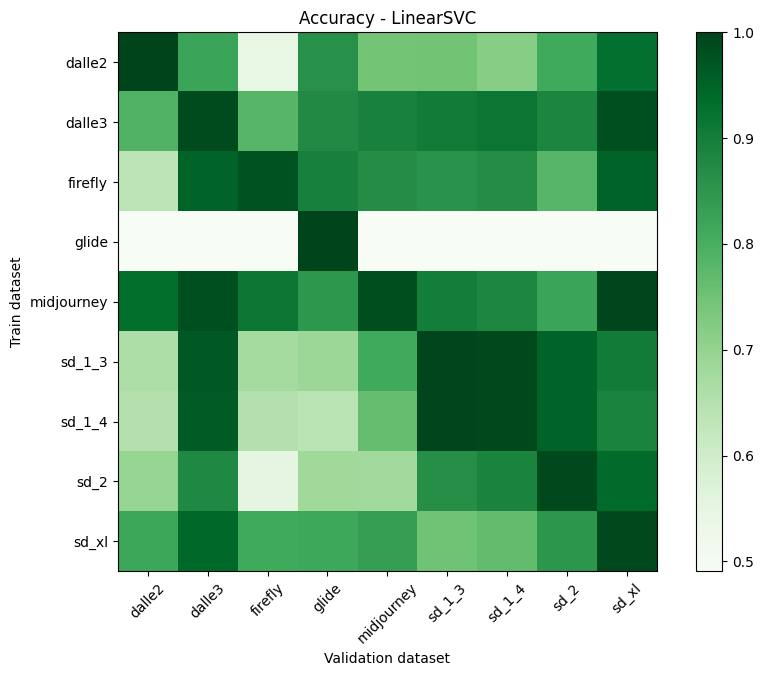

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl
train_dataset,,,,,,,,,
dalle2,1.000000,0.821875,0.540625,0.859375,0.743750,0.746875,0.715625,0.809375,0.928125
dalle3,0.790625,0.987500,0.781250,0.875000,0.890625,0.903125,0.915625,0.884375,0.981250
firefly,0.634375,0.950000,0.975000,0.893750,0.868750,0.856250,0.868750,0.781250,0.950000
glide,0.490625,0.490625,0.490625,1.000000,0.490625,0.490625,0.490625,0.490625,0.490625
midjourney,0.931250,0.981250,0.912500,0.846875,0.984375,0.900000,0.881250,0.821875,0.996875
sd_1_3,0.659375,0.965625,0.671875,0.687500,0.809375,0.996875,0.990625,0.950000,0.903125
sd_1_4,0.650000,0.962500,0.650000,0.637500,0.762500,0.996875,0.990625,0.950000,0.887500
sd_2,0.696875,0.878125,0.550000,0.681250,0.678125,0.865625,0.887500,0.990625,0.937500
sd_xl,0.818750,0.940625,0.809375,0.815625,0.834375,0.750000,0.765625,0.850000,0.990625


In [17]:
# Get only for the Forest model
Forest = df_results[df_results["model"] == "LinearSVC"]
# Leave only the accuracy, train_dataset, and val_dataset columns
Forest = Forest[["train_dataset", "val_dataset", "accuracy"]]
# Pivot the table
df_pivot = Forest.pivot(index="train_dataset", columns="val_dataset", values="accuracy")


plt.figure(figsize=(10, 7))
plt.imshow(df_pivot, cmap='Greens', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
plt.xlabel("Validation dataset")
plt.ylabel("Train dataset")
plt.title("Accuracy - LinearSVC")
plt.show()

df_pivot

In [18]:
# add average accuracy for each train dataset (don't include combined)
df_pivot["average"] = df_pivot.mean(axis=1)
df_pivot

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,1.000000,0.821875,0.540625,0.859375,0.743750,0.746875,0.715625,0.809375,0.928125,0.796181
dalle3,0.790625,0.987500,0.781250,0.875000,0.890625,0.903125,0.915625,0.884375,0.981250,0.889931
firefly,0.634375,0.950000,0.975000,0.893750,0.868750,0.856250,0.868750,0.781250,0.950000,0.864236
glide,0.490625,0.490625,0.490625,1.000000,0.490625,0.490625,0.490625,0.490625,0.490625,0.547222
midjourney,0.931250,0.981250,0.912500,0.846875,0.984375,0.900000,0.881250,0.821875,0.996875,0.917361
sd_1_3,0.659375,0.965625,0.671875,0.687500,0.809375,0.996875,0.990625,0.950000,0.903125,0.848264
sd_1_4,0.650000,0.962500,0.650000,0.637500,0.762500,0.996875,0.990625,0.950000,0.887500,0.831944
sd_2,0.696875,0.878125,0.550000,0.681250,0.678125,0.865625,0.887500,0.990625,0.937500,0.796181
sd_xl,0.818750,0.940625,0.809375,0.815625,0.834375,0.750000,0.765625,0.850000,0.990625,0.841667


## Save models and scaler

In [19]:
import joblib
import os

os.makedirs("models", exist_ok=True)
os.makedirs("scalers", exist_ok=True)

for dataset_name in models.keys():
    for model_name, model in models[dataset_name].items():
        joblib.dump(model, f"models/{model_name}_{dataset_name}.pkl")        
    joblib.dump(scalers[dataset_name], f"scalers/scaler_{dataset_name}.pkl")

## Feature importance

In [20]:
from sklearn.inspection import permutation_importance

def plot_top_importances(clf, X, y, top=10, clf_name=None, random_state=SEED):
    if clf_name is None:
        clf_name = clf.__class__.__name__

    try:
        result = permutation_importance(
            clf, X, y, n_repeats=10, random_state=random_state, n_jobs=-1
        )

        sorted_importances_idx = result.importances_mean.argsort()
        importances = pd.DataFrame(
            result.importances[sorted_importances_idx].T,
            columns=X.columns[sorted_importances_idx],
        )
        
        # plot top 10 features
        sorted_importances_idx_top10 = result.importances_mean.argsort()[-10:]
        importances_top10 = pd.DataFrame(
            result.importances[sorted_importances_idx_top10].T,
            columns=X.columns[sorted_importances_idx_top10],
        )
        ax = importances_top10.plot.box(vert=False, whis=10)
        ax.set_title("Top 10 features")
        ax.axvline(x=0, color="k", linestyle="--")
        ax.set_xlabel("Decrease in accuracy score")
        ax.figure.tight_layout()
        plt.show()
        
        # plot 10 bottom features
        sorted_importances_idx_bottom10 = result.importances_mean.argsort()[:10]
        importances_bottom10 = pd.DataFrame(
            result.importances[sorted_importances_idx_bottom10].T,
            columns=X.columns[sorted_importances_idx_bottom10],
        )
        ax = importances_bottom10.plot.box(vert=False, whis=10)
        ax.set_title("Bottom 10 features")
        ax.axvline(x=0, color="k", linestyle="--")
        ax.set_xlabel("Decrease in accuracy score")
        ax.figure.tight_layout()
        plt.show()
        
        return importances
    except Exception as e:
        print(f"During processing {clf_name}. Exception: {e} occurred.")





 *** Evaluating models trained on dalle2. ***


Validation set: dalle2



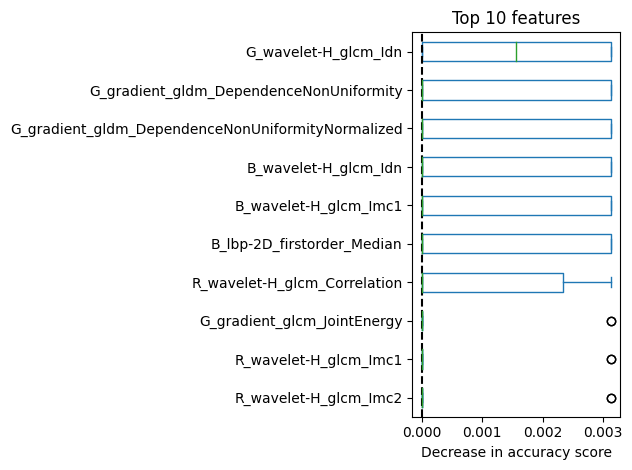

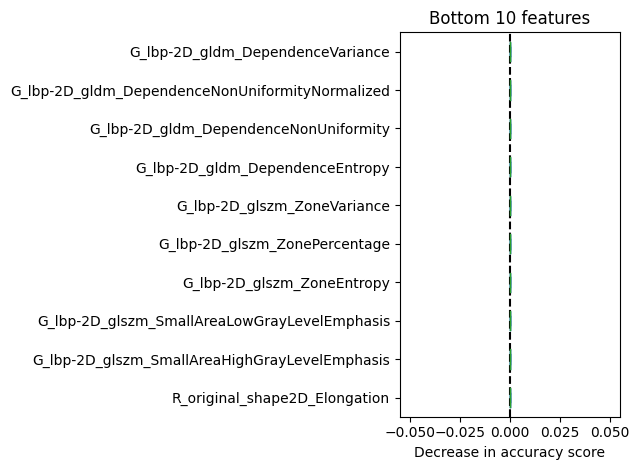





 *** Evaluating models trained on dalle3. ***


Validation set: dalle3



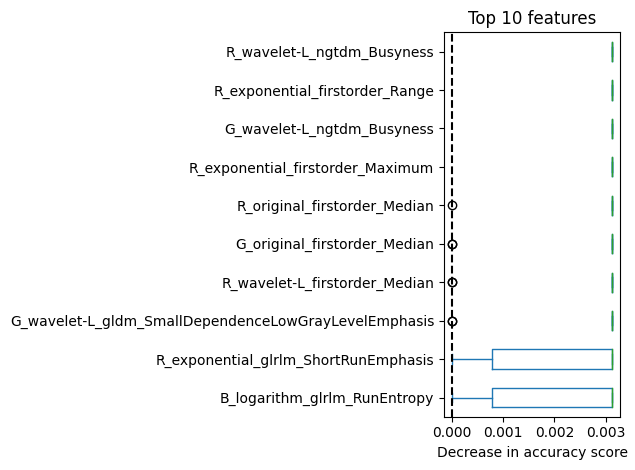

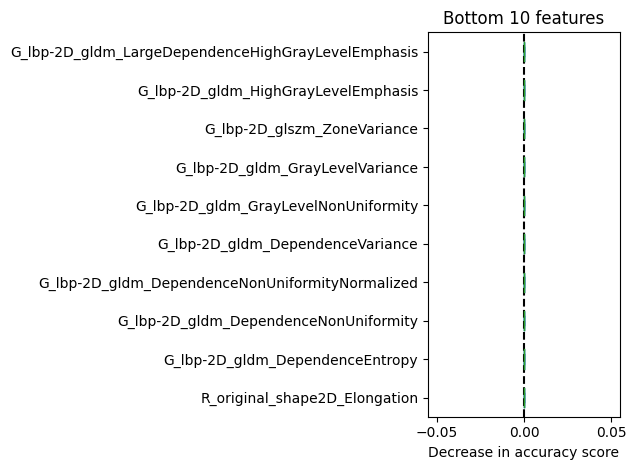





 *** Evaluating models trained on firefly. ***


Validation set: firefly



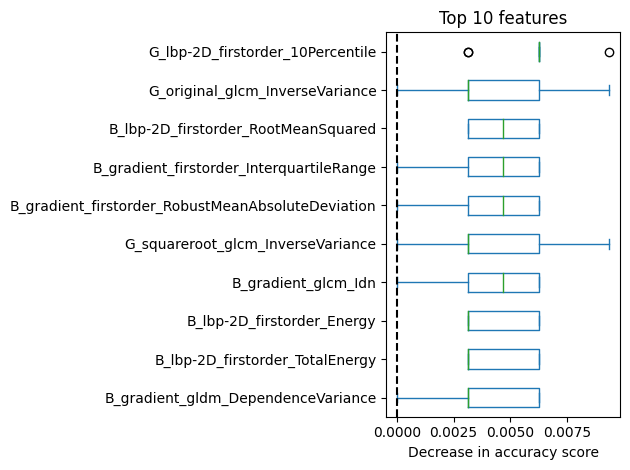

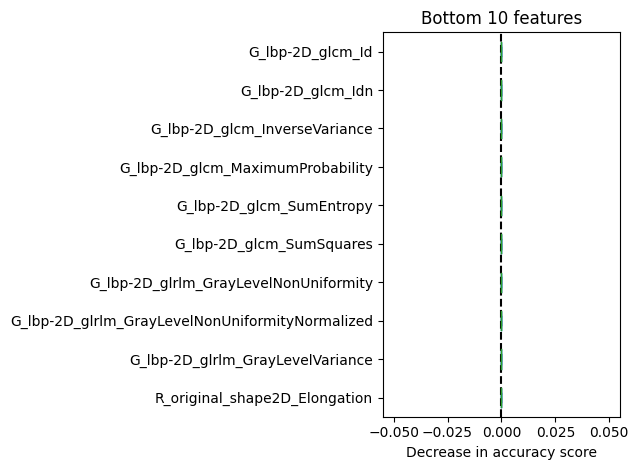





 *** Evaluating models trained on glide. ***


Validation set: glide



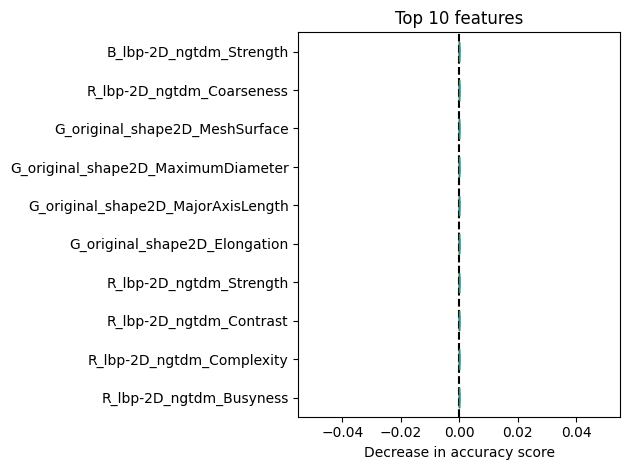

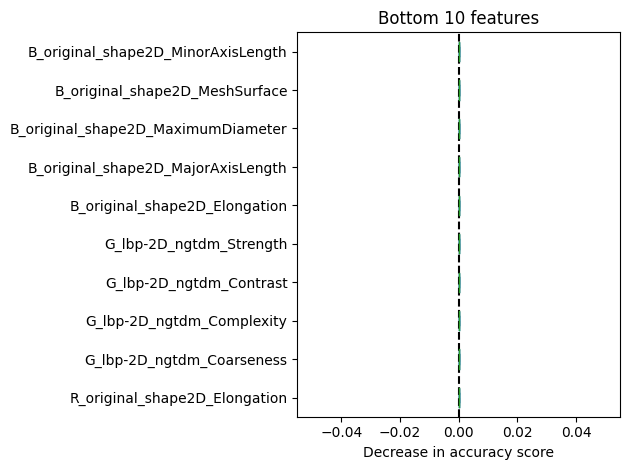





 *** Evaluating models trained on midjourney. ***


Validation set: midjourney



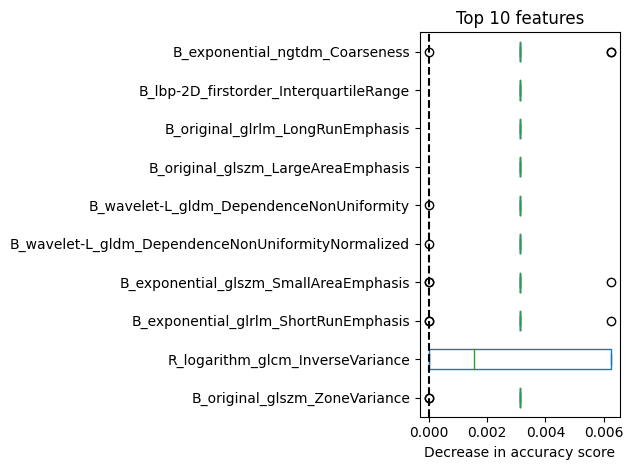

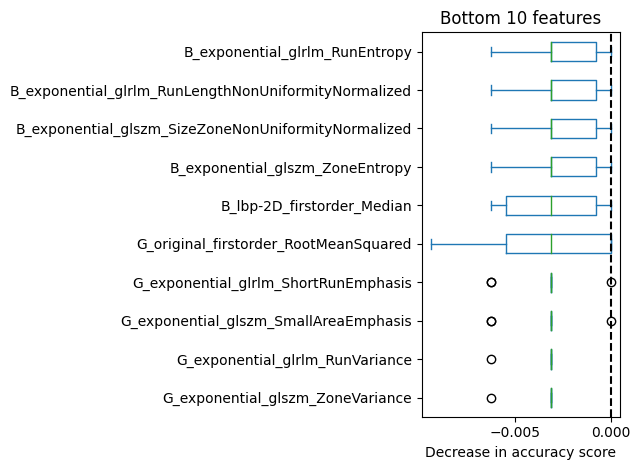





 *** Evaluating models trained on sd_1_3. ***


Validation set: sd_1_3



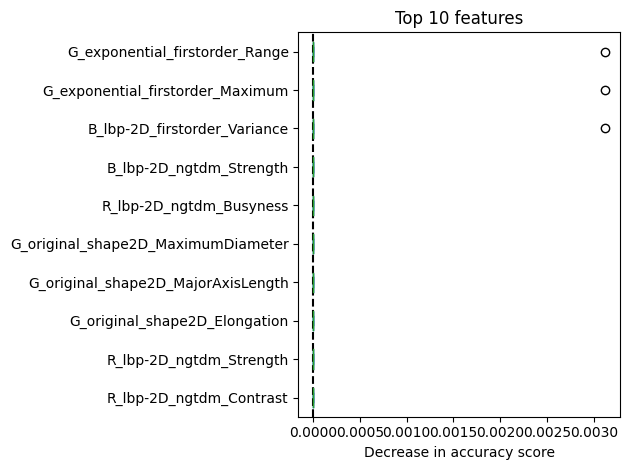

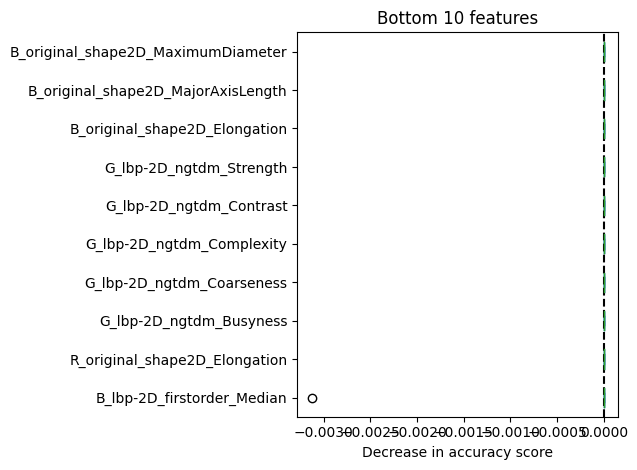





 *** Evaluating models trained on sd_1_4. ***


Validation set: sd_1_4



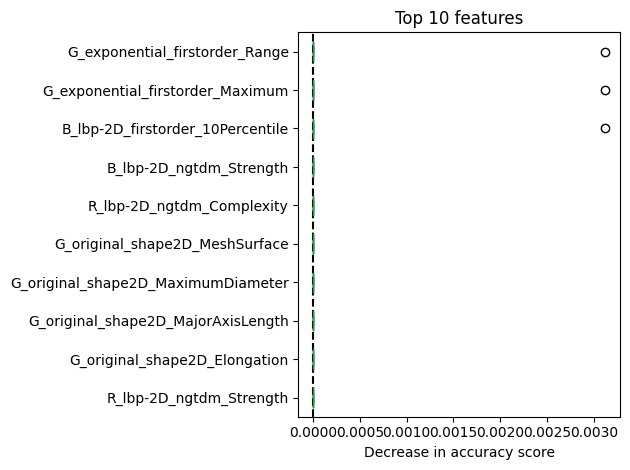

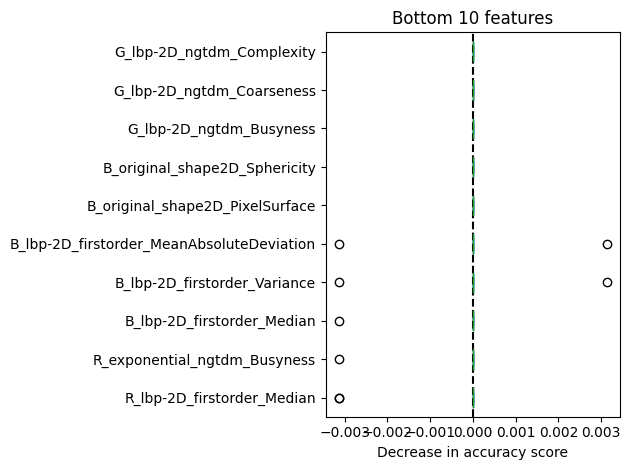





 *** Evaluating models trained on sd_2. ***


Validation set: sd_2



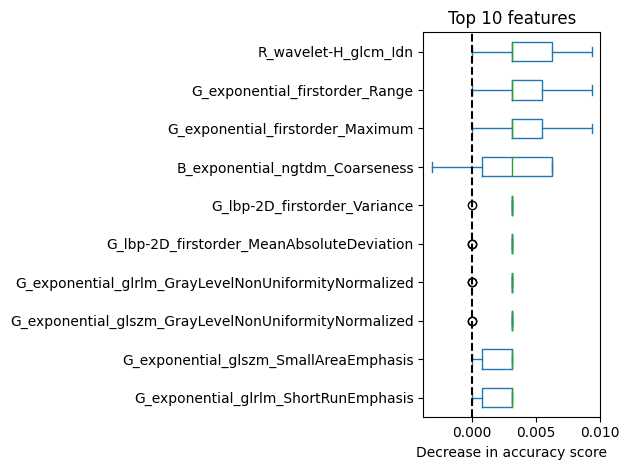

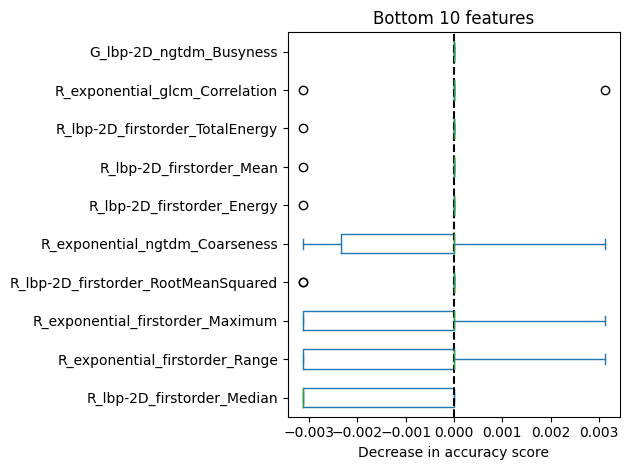





 *** Evaluating models trained on sd_xl. ***


Validation set: sd_xl



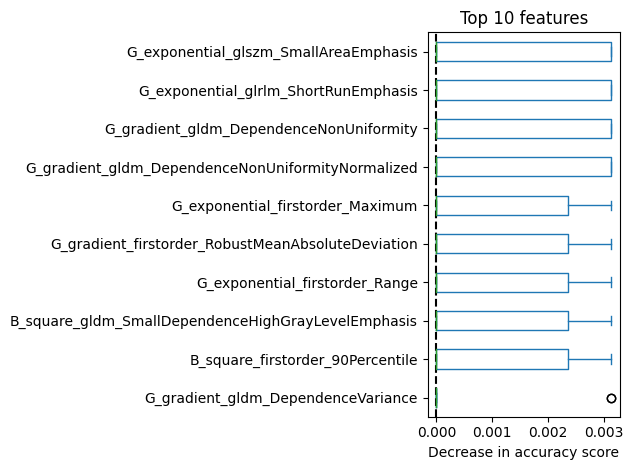

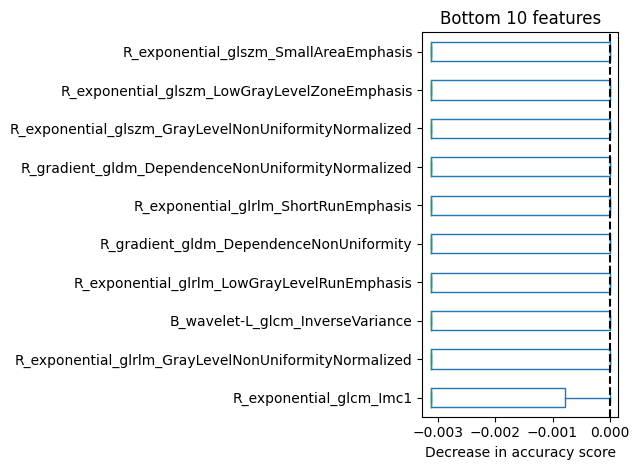

In [21]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for val_dataset_name in X_val.keys():
        if val_dataset_name != dataset_name:
            continue
        print(f"\n\nValidation set: {val_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print()  
            X_val_scaled = scalers[dataset_name].transform(X_val[val_dataset_name])
            X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val[val_dataset_name].columns)
            importances = plot_top_importances(model, X_val_scaled, y_val[val_dataset_name])
            importances.to_csv(f"importances_{model_name}_{dataset_name}_{val_dataset_name}.csv")
            
    